In [1]:
import matplotlib.pyplot as plt 
plt.rcParams.update({
    'font.size': 20,
    'figure.figsize': (12, 6)
})
plt.rc('font', family='arial')

## Non-exonic windows, with Gnocchi and various features (e.g. GC content), and enhancer-overlap status 

In [2]:
from get_windows import get_windows_with_GC_content_and_cpg_islands 

WINDOWS = get_windows_with_GC_content_and_cpg_islands()
WINDOWS 

/scratch/ucgd/lustre-labs/quinlan/data-shared/constraint-tools


,chrom,start,end,gnocchi,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,...,B1_M3starHMT6.EUR,Bmean_M3starHMT6.EUR,lambda_M3starHMT6.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island,N_mean_null_gnocchi
0,chr1,1432000,1433000,4.299894,259,True,False,0.653,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.661339,0.641836,0.565094,0.577534,NaN,False,338.059552
1,chr1,1451000,1452000,0.666316,291,False,False,0.652,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.556444,0.552845,0.572894,0.575506,NaN,False,302.590657
2,chr1,1453000,1454000,0.828398,256,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.537463,0.561944,0.572564,0.575129,NaN,False,269.601925
3,chr1,1458000,1459000,-0.086128,272,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.532468,0.596740,0.570774,0.575225,NaN,False,270.583243
4,chr1,1463000,1464000,2.948188,191,True,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.540460,0.568843,0.576514,0.574420,NaN,False,236.321790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019146,chr9,137262000,137263000,-2.396149,302,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.500499,0.542646,0.611944,0.568316,45.0,True,263.131293
1019147,chr9,137268000,137269000,3.640544,212,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.552448,0.589941,0.613074,0.567839,NaN,False,272.046527
1019148,chr9,137269000,137270000,5.276351,209,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.519481,0.585042,0.613494,0.567623,NaN,False,300.458958
1019149,chr9,137275000,137276000,2.687348,290,True,False,0.536,1.564889,0.024254,...,3.636507,0.219258,2.281162,0.603397,0.639236,0.610484,0.567380,NaN,False,339.517045


## Logistic regression: predicting enhancers as a function of gnocchi, GC_content, gBGC and BGS 

In [3]:
GC_WINDOW_SIZE = 1000

1019151
1018648
Coefficient for gnocchi: 0.3861785638203597
Coefficient for GC_content_1000bp: 0.4604321928413986
Coefficient for B_M1star.EUR: 0.06279641753457087
Coefficient for B: -0.09050655923678144


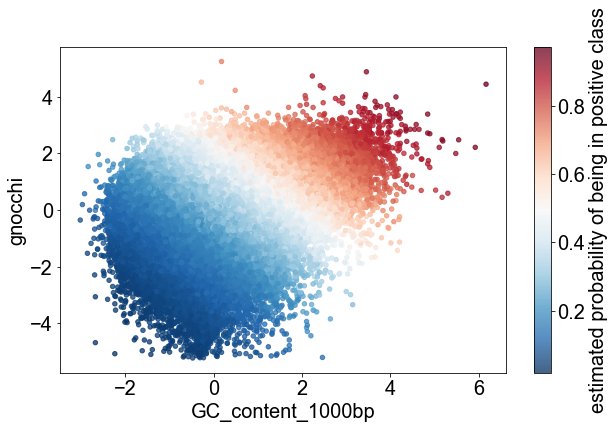

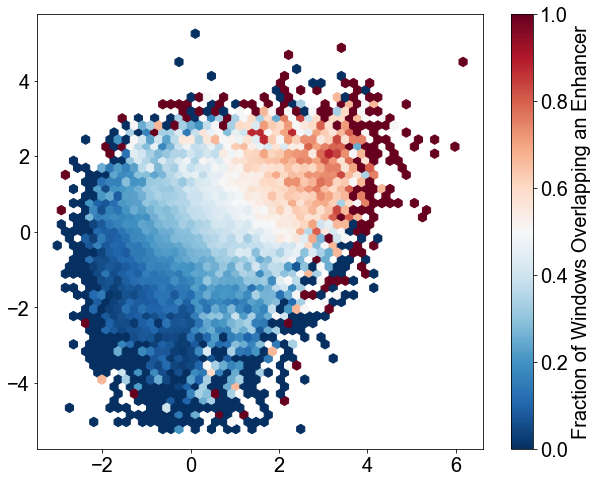

negative log likelihood: 115880.34387041951
Area Under the Precision-Recall Curve (AUPRC): 0.48286313261979785
positive fraction: 0.3075246649977912


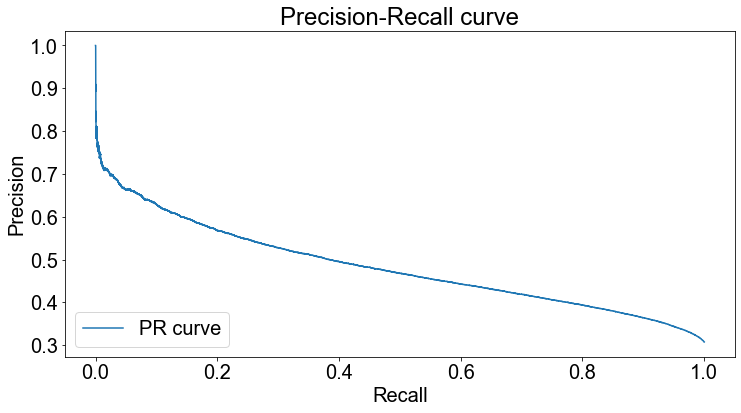

In [4]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

def plot_fraction_of_windows_that_overlap_enhancer(df, x, y):
    df = pd.DataFrame({
        'x': x,
        'y': y
    })

    # Define the number of bins
    num_bins = 10

    # Create bins of x
    df['bins'] = pd.cut(df['x'], bins=num_bins)

    # Compute the average of y in each bin
    bin_means = df.groupby('bins')['y'].mean()

    # Plot the averages against the bins
    plt.figure(figsize=(10, 6))
    bin_means.plot(kind='bar')
    plt.xlabel('Bins of x')
    plt.ylabel('Average of y')
    plt.show()
   
def compute_negative_log_likelihood(y_true, y_pred_prob):
    # Compute log likelihood
    log_likelihood = y_true * np.log(y_pred_prob) + (1 - y_true) * np.log(1 - y_pred_prob)

    # Return negative log likelihood
    return -np.sum(log_likelihood)

def logistic_regression_heatmap(df, features, target, features_to_plot):
    df = df.copy()

    print(len(df))
    # drop records with NaN values in any of the columns in "features": 
    df = df.dropna(subset=features)
    print(len(df))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

    # Initialize a StandardScaler
    scaler = StandardScaler()

    # Fit the scaler with the training data and transform both training and testing data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize a PolynomialFeatures object
    poly = PolynomialFeatures(degree=1, interaction_only=True, include_bias=False) # explored degree=2, too 

    # Fit and transform the training data
    X_train_poly = poly.fit_transform(X_train)

    # Transform the testing data
    X_test_poly = poly.transform(X_test)

    # Initialize a Logistic Regression model
    logreg = LogisticRegression(penalty='l2', C=100) # TODO: how does this affect likelihood calculation?

    # Fit the model with the training data
    logreg.fit(X_train_poly, y_train)

    # Predict the probabilities
    y_pred_prob = logreg.predict_proba(X_test_poly)[:, 1]

    # Get the feature names from the PolynomialFeatures object
    feature_names = poly.get_feature_names_out(input_features=features)

    # Print the coefficients of the features
    for feature, coef in zip(feature_names, logreg.coef_[0]):
        print(f'Coefficient for {feature}: {coef}')

    features_to_plot_indices = []
    for feature_to_plot in features_to_plot:
      features_to_plot_indices.append(features.index(feature_to_plot))
    
    x = np.array(X_test[:,features_to_plot_indices[0]]) # type: ignore
    if len(features_to_plot) > 1:
      y = np.array(X_test[:,features_to_plot_indices[1]]) # type: ignore
    c = y_pred_prob
    C = y_test

    if len(features_to_plot) > 1:
      # https://github.com/pandas-dev/pandas/issues/10611#issuecomment-522327555
      fig, axis = plt.subplots(figsize=(10,6))
      plt.scatter(x, y, c=c, s=20, cmap='RdBu_r', alpha=0.75) 
      plt.xlabel(features[features_to_plot_indices[0]])
      plt.ylabel(features[features_to_plot_indices[1]])
      cbar = plt.colorbar()
      cbar.set_label('estimated probability of being in positive class')
      plt.show() 
    else: 
      plt.figure(figsize=(10, 6))
      plt.scatter(x, c, s=20, cmap='RdBu_r', alpha=0.75) 
      plt.xlabel(features[features_to_plot_indices[0]])
      plt.ylabel('estimated probability of being in positive class')
      plt.show()

    if len(features_to_plot) > 1:
      # Plot the fraction as a hexbin plot
      plt.figure(figsize=(10, 8))
      plt.hexbin(x, y, C=C, gridsize=50, cmap='RdBu_r', reduce_C_function=np.mean)
      plt.colorbar(label='Fraction of Windows Overlapping an Enhancer')
      plt.show()
    else: 
      plot_fraction_of_windows_that_overlap_enhancer(df, x, C)

    print(f'negative log likelihood: {compute_negative_log_likelihood(y_true=y_test, y_pred_prob=y_pred_prob)}')

    if len(features) == 1:
      precision, recall, thresholds = precision_recall_curve(y_test, x)
    else: 
      precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    auprc = auc(recall, precision)
    print(f'Area Under the Precision-Recall Curve (AUPRC): {auprc}')

    print(f'positive fraction: {np.mean(y_test)}')

    # Plot PR curve
    plt.figure()
    plt.plot(recall, precision, label='PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc='lower left')
    plt.show()

# Call the function
logistic_regression_heatmap(WINDOWS, features=['gnocchi', f'GC_content_{GC_WINDOW_SIZE}bp', 'B_M1star.EUR', 'B'], target='window overlaps enhancer', features_to_plot=[f'GC_content_{GC_WINDOW_SIZE}bp', 'gnocchi'])

1019151
1018648
Coefficient for gnocchi: 0.3861785638203597
Coefficient for GC_content_1000bp: 0.4604321928413986
Coefficient for B_M1star.EUR: 0.06279641753457087
Coefficient for B: -0.09050655923678144


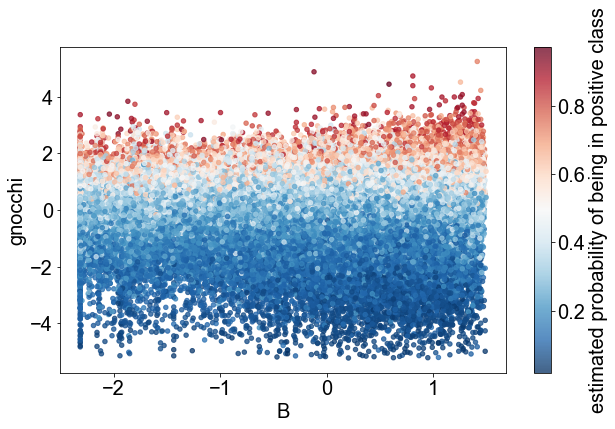

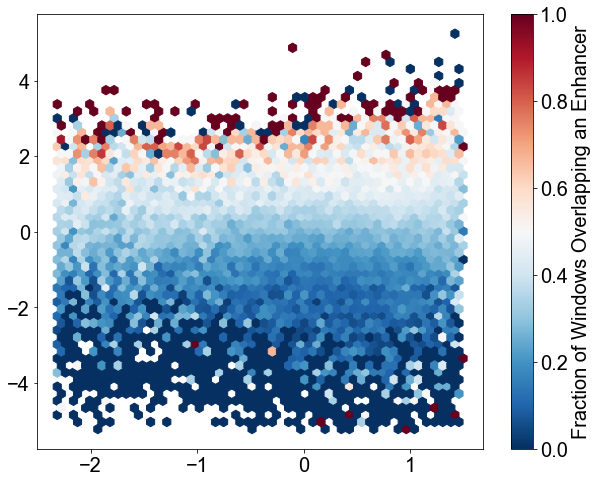

negative log likelihood: 115880.34387041951
Area Under the Precision-Recall Curve (AUPRC): 0.48286313261979785
positive fraction: 0.3075246649977912


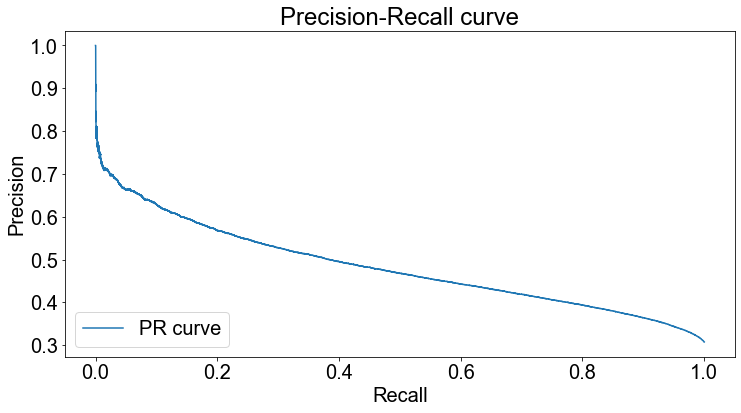

In [5]:
logistic_regression_heatmap(WINDOWS, features=['gnocchi', f'GC_content_{GC_WINDOW_SIZE}bp', 'B_M1star.EUR', 'B'], target='window overlaps enhancer', features_to_plot=['B', 'gnocchi'])

1019151
1019151
Coefficient for gnocchi: 0.5575198804481459


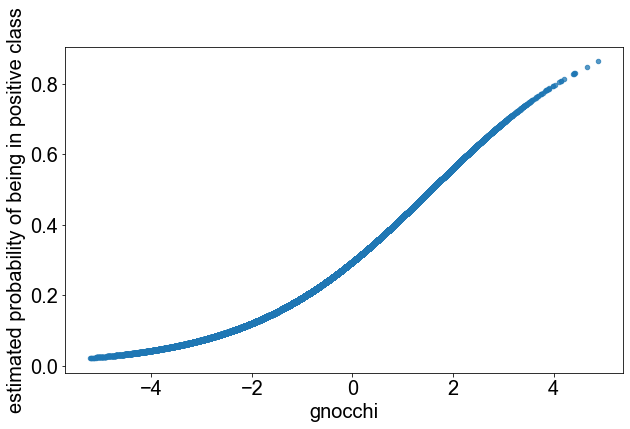

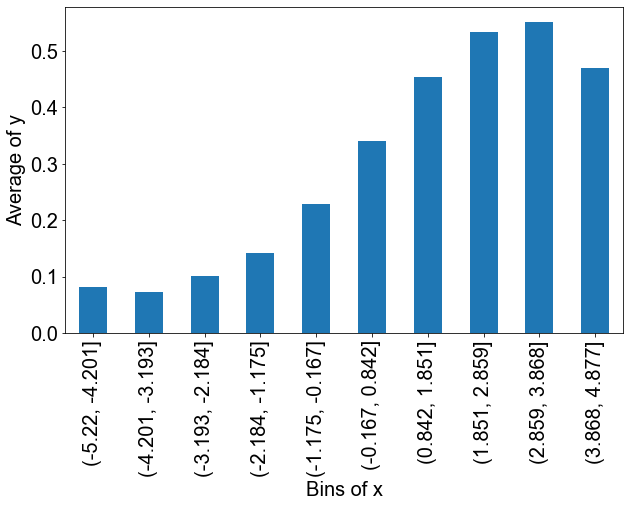

negative log likelihood: 120314.55979143808
Area Under the Precision-Recall Curve (AUPRC): 0.4229838174902263
positive fraction: 0.30801006716348345


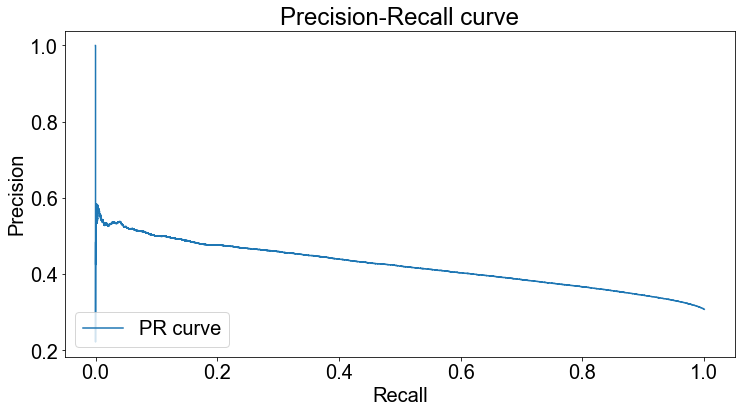

In [6]:
logistic_regression_heatmap(WINDOWS, features=['gnocchi'], target='window overlaps enhancer', features_to_plot=['gnocchi'])

1019151
1019151
Coefficient for GC_content_1000bp: 0.5764062844271732


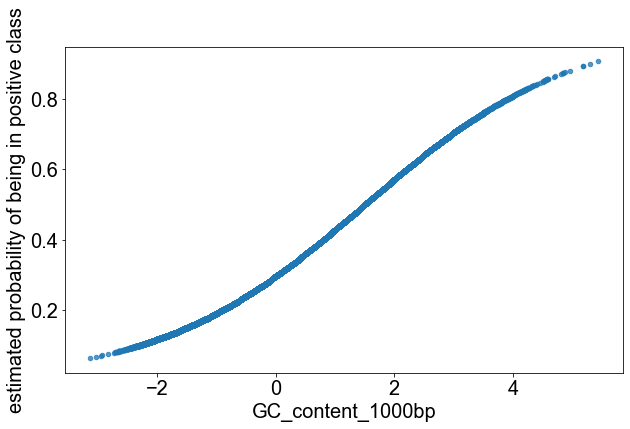

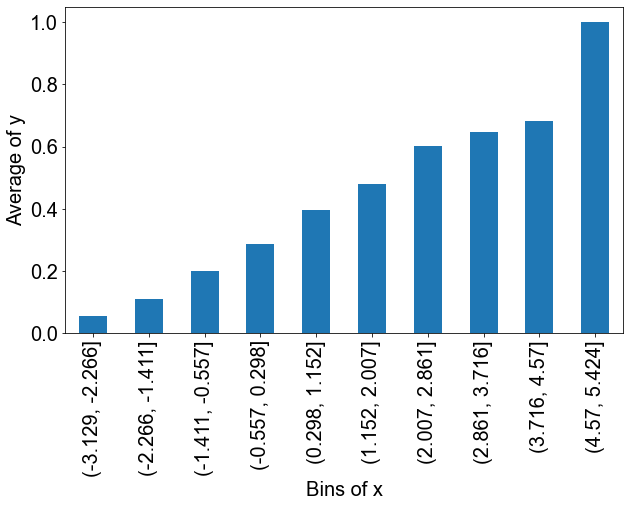

negative log likelihood: 119145.80049392904
Area Under the Precision-Recall Curve (AUPRC): 0.4516145875793207
positive fraction: 0.30801006716348345


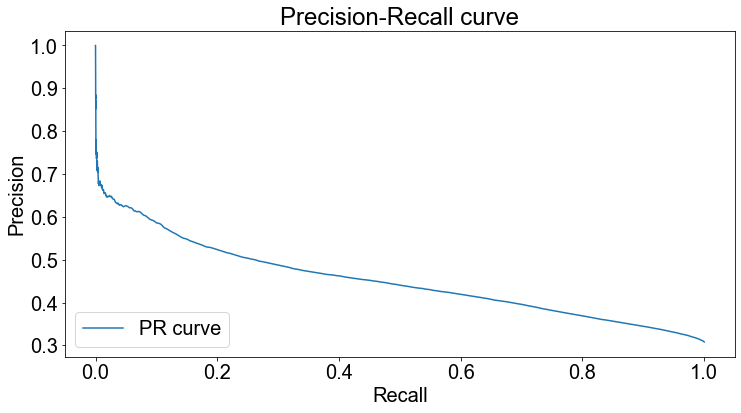

In [7]:
logistic_regression_heatmap(WINDOWS, features=[f'GC_content_{GC_WINDOW_SIZE}bp'], target='window overlaps enhancer', features_to_plot=[f'GC_content_{GC_WINDOW_SIZE}bp'])

In [10]:
# possible narrative: 

# 0. state that we'd like to rank the importance of each feature 
# 1. Point out that PR curves are unable to determine which of the features has the greatest effect on Gnocchi performance, 
#    as the flatness of the B distribution allows us to detect signal at more extreme values of B, 
#    than for GC content and gBGC, which have shallower tails. 
#    [should probably demonstrate this phenomenon by simulation]
# 2. We therefore decided to use logistic regression to determine the effect size of each feature on the probability of a window overlapping an enhancer
# 3. We found that the effect size of GC content was much greater than that of BGS and gBGC, which had little effect on the probability of a window overlapping an enhancer
# 4. We could confirm this by: 
#    i. LRT statistic (https://gist.github.com/petermchale/0aa9b944edb0bb18e4701044dd915d66), where we consider three alternative models: 
#        a. gnocchi only
#        b. gnocchi + GC content
#        c. gnocchi + BGS
#        d. gnocchi + gBGC
#        and ask which feature represents the greatest improvement in model fit (relative to a.). Expect to find that b. has the largest LRT statistic 

In [11]:
# TODO [Michael]

# compute p-values of smallest regression coefficients, to demonstrate that there is a significant effect 

In [12]:
# TODO: [Michael]

# 1. use experiments/germline-model/chen-et-al-2022/MANIFEST.md to confirm that experiments/germline-model/chen-et-al-2022/Fig_2a.ipynb was used to label windows as overlapping enhancer or not
# 2. if so, then, in that notebook, redefine "ambiguous" category for enhancer-overlap from (0, 10) to e.g., (0, 500), 
#    so that we are more confident that windows with window_overlaps_enhancer==True are constrained, 
#    which hopefully will make our results more "crisp"